In [1]:
import os
import random

import pickle
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import tensorflow as tf

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, MaxNLocator


custom_seed = 42
np.random.seed(custom_seed)
tf.random.set_seed(custom_seed)

2025-02-14 14:39:48.432451: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-14 14:39:48.484562: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-14 14:39:48.484607: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-14 14:39:48.484639: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-14 14:39:48.493598: I tensorflow/core/platform/cpu_feature_g

In [2]:
tf.config.set_visible_devices([], 'GPU')

In [3]:
problem = "nonlinear_problem_P4"

In [4]:
data_folder = r'/home/rmunoz/Escritorio/rmunozTMELab/PGNNIV-to-Continuum-Problems/data'
results_folder = rf'/home/rmunoz/Escritorio/rmunozTMELab/PGNNIV-to-Continuum-Problems/results/nonlinear_problem_P4_results'

print(data_folder)
print(results_folder)

/home/rmunoz/Escritorio/rmunozTMELab/PGNNIV-to-Continuum-Problems/data
/home/rmunoz/Escritorio/rmunozTMELab/PGNNIV-to-Continuum-Problems/results/nonlinear_problem_P4_results


In [5]:
data_path = os.path.join(data_folder, f'{problem}_data.pkl')
first_training_result_path = os.path.join(results_folder, f'{problem}_first_train.pkl')
second_training_result_path = os.path.join(results_folder, f'{problem}_first_train.pkl')

print(data_path)
print(first_training_result_path)
print(second_training_result_path)

/home/rmunoz/Escritorio/rmunozTMELab/PGNNIV-to-Continuum-Problems/data/nonlinear_problem_P4_data.pkl
/home/rmunoz/Escritorio/rmunozTMELab/PGNNIV-to-Continuum-Problems/results/nonlinear_problem_P4_results/nonlinear_problem_P4_first_train.pkl
/home/rmunoz/Escritorio/rmunozTMELab/PGNNIV-to-Continuum-Problems/results/nonlinear_problem_P4_results/nonlinear_problem_P4_first_train.pkl


In [6]:
# Load data
with open(data_path, 'rb') as f:
    data = pickle.load(f)

# Load first training
with open(first_training_result_path, 'rb') as f:
    results_first_train_pkl = pickle.load(f)

results_first_train = results_first_train_pkl['training']
predictions_predictive_first_train = results_first_train_pkl['predictions_pred']
predictions_explanatory_first_train = results_first_train_pkl['predictions_exp']

# Load second training
with open(second_training_result_path, 'rb') as f:
    results_second_train_pkl = pickle.load(f)

results_second_train = results_second_train_pkl['training']
predictions_predictive_second_train = results_second_train_pkl['predictions_pred']
predictions_explanatory_second_train = results_second_train_pkl['predictions_exp']

In [7]:
n_data = data['n_data']
n_discretization = data['n_discretization']
x_step_size = data['x_step_size']
y_step_size = data['y_step_size']

Functions that are necessary 

In [8]:
# Finite difference convolutional operator to derivate in x axis
def Dx(f, x_step_size=x_step_size):
    Dx = tf.constant([[-1, +1], 
                      [-1, +1]], 
                     dtype=tf.float32)/(2*x_step_size)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Dx = tf.expand_dims(tf.expand_dims(Dx, axis=-1), axis=-1)
    dfdx = tf.nn.conv2d(f_reshaped, Dx, strides=[1, 1, 1, 1], padding='VALID', name='dfdx')
    return tf.squeeze(dfdx, axis=-1)

# Finite difference convolutional operator to derivate in y axis
def Dy(f, y_step_size=y_step_size):
    Dy = tf.constant([[+1, +1], 
                      [-1, -1]],  
                     dtype=tf.float32)/(-2*y_step_size)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Dy = tf.expand_dims(tf.expand_dims(Dy, axis=-1), axis=-1)
    dfdy = tf.nn.conv2d(f_reshaped, Dy, strides=[1, 1, 1, 1], padding='VALID', name='dfdy')
    return tf.squeeze(dfdy, axis=-1)

# Convolutional operator to do the mean between two elements of a mesh in x axis
def Mx(f):
    Mx = tf.constant([[+1, +1]], 
                     dtype=tf.float32)/(2)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Mx = tf.expand_dims(tf.expand_dims(Mx, axis=-1), axis=-1)
    x_avg = tf.nn.conv2d(f_reshaped, Mx, strides=[1, 1, 1, 1], padding='VALID', name='Mx')
    return tf.squeeze(x_avg, axis=-1)

# Convolutional operator to do the mean between two elements of a mesh in y axis
def My(f):
    My = tf.constant([[+1], 
                      [+1]], 
                     dtype=tf.float32)/(2)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    My = tf.expand_dims(tf.expand_dims(My, axis=-1), axis=-1)
    y_avg = tf.nn.conv2d(f_reshaped, My, strides=[1, 1, 1, 1], padding='VALID', name='My')
    return tf.squeeze(y_avg, axis=-1)

In [9]:
def smooth_curve(data, window_size=50):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = max(lst)
    return [x / max_value for x in lst]

Graphics parameters

In [10]:
linewidth = 1.5
title_fontsize = 14
label_fontsize = 14
legend_fontsize = 12
tick_fontsize = 11

# plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10)
posY = cm_to_in(10)
width = cm_to_in(16)
height = cm_to_in(8)

color = [0.1, 0, 0.8]
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

In [11]:
if problem == "nonlinear_problem_P4":
    training_curves_color = 'black'

elif problem == "nonlinear_problem_P4":
    training_curves_color = 'green'

else:
    training_curves_color = 'blue'

# Model

In [12]:
# @tf.keras.utils.register_keras_serializable()
# class NeuralNetwork(tf.keras.Model):

#     def __init__(self, input_size, hidden1_dim, hidden2_dim, output_size, n_filters=15, **kwargs):
#         super(NeuralNetwork, self).__init__(**kwargs)
        
#         self.input_size = input_size
#         self.hidden1_dim = hidden1_dim
#         self.hidden2_dim = hidden2_dim
#         self.output_size = output_size
#         self.n_filters = n_filters

#         # Predictive network
#         self.flatten_layer_pred = tf.keras.layers.Flatten(name="flatten_layer_pred")
#         self.hidden1_layer_pred = tf.keras.layers.Dense(hidden1_dim, activation='sigmoid', name="hidden1_layer_pred")
#         self.hidden2_layer_pred = tf.keras.layers.Dense(hidden2_dim, activation='sigmoid', name="hidden2_layer_pred")
#         self.output_layer_pred = tf.keras.layers.Dense(output_size[0] * output_size[1], activation=None, name="output_layer_pred")

#         # Explanatory network
#         self.conv1_exp = tf.keras.layers.Conv2D(n_filters, (1, 1), activation='sigmoid', name="conv1_exp")
#         self.flatten_layer_exp = tf.keras.layers.Flatten(name="flatten_layer_exp")
#         self.hidden1_layer_exp = tf.keras.layers.Dense(hidden1_dim, activation='sigmoid', name="hidden1_layer_exp")
#         self.hidden2_layer_exp = tf.keras.layers.Dense(hidden2_dim, activation='sigmoid', name="hidden2_layer_exp")
#         self.output_layer_exp = tf.keras.layers.Dense(n_filters * (output_size[0] - 1) * (output_size[1] - 1), name="output_layer_exp")
#         self.conv2_exp = tf.keras.layers.Conv2D(1, (1, 1), activation=None, name="conv2_exp")

#     def call(self, X):
        
#         # Predictive network
#         X_pred_flat = self.flatten_layer_pred(X)
#         X_pred_hidden1 = self.hidden1_layer_pred(X_pred_flat)
#         X_pred_hidden2 = self.hidden2_layer_pred(X_pred_hidden1)
#         output_dense_pred = self.output_layer_pred(X_pred_hidden2)

#         # Average operator along x and y directions
#         u_pred = tf.reshape(output_dense_pred, [tf.shape(output_dense_pred)[0], self.output_size[0], self.output_size[1]])
#         um_pred = Mx(My(u_pred))

#         # Explanatory network
#         conv_output_exp = self.conv1_exp(tf.expand_dims(um_pred, axis=-1))
#         conv_output_flat_exp = self.flatten_layer_exp(conv_output_exp)
#         X_exp_hidden1 = self.hidden1_layer_exp(conv_output_flat_exp)
#         X_exp_hidden2 = self.hidden2_layer_exp(X_exp_hidden1)
#         output_exp = self.output_layer_exp(X_exp_hidden2)
#         output_exp_reshaped = tf.reshape(output_exp, (um_pred.shape[0], um_pred.shape[1], um_pred.shape[2], self.n_filters))
#         K_pred = tf.squeeze(self.conv2_exp(output_exp_reshaped), axis=-1)

#         return u_pred, K_pred
    
#     def explanatory_network(self, u_pred):

#         um_pred = Mx(My(u_pred))

#         # Explanatory network
#         conv_output_exp = self.conv1_exp(tf.expand_dims(um_pred, axis=-1))
#         conv_output_flat_exp = self.flatten_layer_exp(conv_output_exp)
#         X_exp_hidden1 = self.hidden1_layer_exp(conv_output_flat_exp)
#         X_exp_hidden2 = self.hidden2_layer_exp(X_exp_hidden1)
#         output_exp = self.output_layer_exp(X_exp_hidden2)
#         output_exp_reshaped = tf.reshape(output_exp, (um_pred.shape[0], um_pred.shape[1], um_pred.shape[2], self.n_filters))
#         K_pred = tf.squeeze(self.conv2_exp(output_exp_reshaped), axis=-1)

#         return K_pred
    
#     def get_config(self):
#         base_config = super().get_config()
#         config = {
#             "input_size": self.input_size,
#             "hidden1_dim": self.hidden1_dim,
#             "hidden2_dim": self.hidden2_dim,
#             "output_size": self.output_size,
#             "n_filters": self.n_filters,
#         }
#         return {**base_config, **config}

#     @classmethod
#     def from_config(cls, config):
#         return cls(**config)

In [13]:
# input_shape = data['X_val'].shape
# hidden1_dim = 150
# hidden2_dim = 150
# output_shape = data['y_val'][0].shape

In [14]:
# model_loaded = NeuralNetwork(input_shape, hidden1_dim, hidden2_dim, output_shape)
# model_loaded.build(input_shape)

In [15]:
# weights_path = os.path.join(results_folder, f'{problem}_new_train.weights.h5')
# model_loaded.load_weights(weights_path, by_name=True)

In [16]:
# U_prueba = tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(data['u_val'], dtype=tf.float32)[:, 0, 0], axis=-1), axis=-1)
# U_prueba = tf.convert_to_tensor(data['u_val'], dtype=tf.float32)
# U_prueba = tf.expand_dims(tf.convert_to_tensor(data['u_val'], dtype=tf.float32)[0], axis=0)

# model_loaded.explanatory_network(U_prueba)

In [17]:
@tf.keras.utils.register_keras_serializable()
class NeuralNetwork2(tf.keras.Model):

    def __init__(self, input_size, hidden1_dim, hidden2_dim, output_size, n_filters=5, **kwargs):
        super(NeuralNetwork2, self).__init__(**kwargs)
        
        self.input_size = input_size
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim
        self.output_size = output_size
        self.n_filters = n_filters

        # Predictive network
        self.flatten_layer_pred = tf.keras.layers.Flatten(name="flatten_layer_pred")
        self.hidden1_layer_pred = tf.keras.layers.Dense(hidden1_dim, activation='sigmoid', name="hidden1_layer_pred")
        self.hidden2_layer_pred = tf.keras.layers.Dense(hidden2_dim, activation='sigmoid', name="hidden2_layer_pred")
        self.output_layer_pred = tf.keras.layers.Dense(output_size[0] * output_size[1], activation=None, name="output_layer_pred")

        # Explanatory network
        self.conv_expand_layer = tf.keras.layers.Conv2D(self.n_filters, (1, 1), activation=None, name="conv_expand_layer")
        self.hidden_layer_1 = tf.keras.layers.Dense(hidden1_dim, activation='sigmoid', name="hidden_layer_1")
        self.hidden_layer_2 = tf.keras.layers.Dense(self.n_filters, activation='sigmoid', name="hidden_layer_2")
        self.conv_converge_layer = tf.keras.layers.Conv2D(1, (1, 1), activation=None, name="conv_converge_layer")

    def call(self, X):
        
        # Predictive network
        X_pred_flat = self.flatten_layer_pred(X)
        X_pred_hidden1 = self.hidden1_layer_pred(X_pred_flat)
        X_pred_hidden2 = self.hidden2_layer_pred(X_pred_hidden1)
        output_dense_pred = self.output_layer_pred(X_pred_hidden2)

        # Average operator along x and y directions
        u_pred = tf.reshape(output_dense_pred, [tf.shape(output_dense_pred)[0], self.output_size[0], self.output_size[1]])
        um_pred = Mx(My(u_pred))
        X = tf.expand_dims(um_pred, axis=-1)
        batch_size, height, width, channels = tf.shape(X)[0], tf.shape(X)[1], tf.shape(X)[2], tf.shape(X)[3]
        X = self.conv_expand_layer(X)  # (batch, height, width, n_filters)        
        X = tf.reshape(X, (batch_size * height * width, self.n_filters))  # Flatten spatial dimensions

        # Apply two dense layers (hidden layers)
        X = self.hidden_layer_1(X)
        X = self.hidden_layer_2(X)
        X = tf.reshape(X, (batch_size, height, width, self.n_filters))
        K_pred = tf.squeeze(self.conv_converge_layer(X), axis=-1)

        return u_pred, K_pred
    
    def explanatory_network(self, u_pred):

        X = tf.expand_dims(u_pred, axis=-1)
        batch_size, height, width, channels = tf.shape(X)[0], tf.shape(X)[1], tf.shape(X)[2], tf.shape(X)[3]
        X = self.conv_expand_layer(X)  # (batch, height, width, n_filters)        
        X = tf.reshape(X, (batch_size * height * width, self.n_filters))  # Flatten spatial dimensions

        # Apply two dense layers (hidden layers)
        X = self.hidden_layer_1(X)
        X = self.hidden_layer_2(X)
        X = tf.reshape(X, (batch_size, height, width, self.n_filters))
        K_pred = tf.squeeze(self.conv_converge_layer(X), axis=-1)

        return K_pred
    
    def get_config(self):
        base_config = super().get_config()
        config = {
            "input_size": self.input_size,
            "hidden1_dim": self.hidden1_dim,
            "hidden2_dim": self.hidden2_dim,
            "output_size": self.output_size,
            "n_filters": self.n_filters,
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [18]:
input_shape = data['X_val'].shape
hidden1_dim = 150
hidden2_dim = 150
output_shape = data['y_val'][0].shape

In [19]:
model_2 = NeuralNetwork2(input_shape, hidden1_dim, hidden2_dim, output_shape)
model_2.build(input_shape)

In [20]:
U_prueba = tf.expand_dims(tf.expand_dims(tf.expand_dims(Mx(My(tf.convert_to_tensor(data['u_val'], dtype=tf.float32)))[0, 0, 0], axis=-1), axis=-1), axis=-1)
# U_prueba = tf.convert_to_tensor(data['u_val'], dtype=tf.float32)
model_2.explanatory_network(U_prueba)

<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[0.2983304]]], dtype=float32)>

Training curves

In [21]:
train_total_loss_list = results_first_train['train_total_loss_list'] + results_second_train['train_total_loss_list']
test_total_loss_list = results_first_train['test_total_loss_list'] + results_second_train['test_total_loss_list']

train_total_MSE_list = results_first_train['train_total_MSE_list'] + results_second_train['train_total_MSE_list']
test_total_MSE_list = results_first_train['test_total_MSE_list'] + results_second_train['test_total_MSE_list']

In [22]:
# This step will be done if data haven't been normalized when results are beeing saved after each training iteration
N_val = data['X_val'].shape[0]
N_batch = 64

train_total_loss_list = [x / N_batch for x in train_total_loss_list]
test_total_loss_list = [x / N_val for x in test_total_loss_list]

train_total_MSE_list = [x / N_batch for x in train_total_MSE_list]
test_total_MSE_list = [x / N_val for x in test_total_MSE_list]

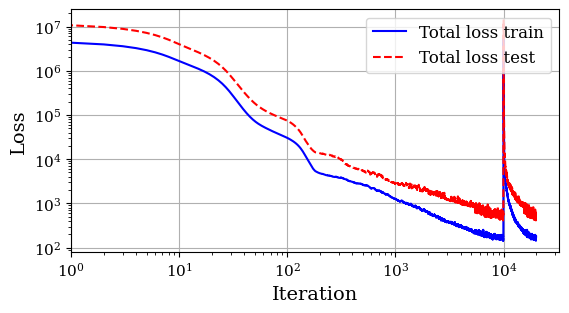

In [23]:
plt.figure(figsize=(width, height))

plt.plot(smooth_curve(train_total_loss_list), label='Total loss train', color='blue', linestyle='-')
plt.plot(smooth_curve(test_total_loss_list), label='Total loss test', color='red', linestyle='--')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Loss', fontsize=label_fontsize)

plt.grid(True)
plt.legend(loc='upper right', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1) 

plt.show()

In [24]:
train_e_loss_list = results_first_train['train_e_loss_list'] + results_second_train['train_e_loss_list']
train_pi1_loss_list = results_first_train['train_pi1_loss_list'] + results_second_train['train_pi1_loss_list']
train_pi2_loss_list = results_first_train['train_pi2_loss_list'] + results_second_train['train_pi2_loss_list']
train_pi3_loss_list = results_first_train['train_pi3_loss_list'] + results_second_train['train_pi3_loss_list']

test_e_loss_list = results_first_train['test_e_loss_list'] + results_second_train['test_e_loss_list']
test_pi1_loss_list = results_first_train['test_pi1_loss_list'] + results_second_train['test_pi1_loss_list']
test_pi2_loss_list = results_first_train['test_pi2_loss_list'] + results_second_train['test_pi2_loss_list']
test_pi3_loss_list = results_first_train['test_pi3_loss_list'] + results_second_train['test_pi3_loss_list']

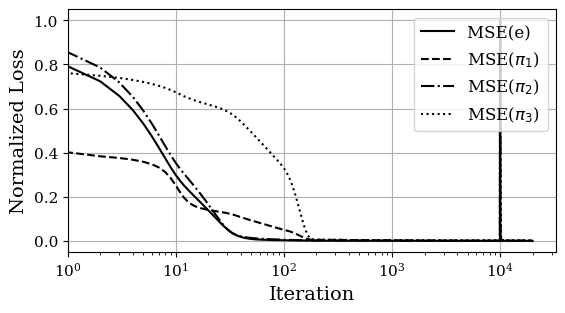

In [25]:
plt.figure(figsize=(width, height))

plt.plot(normalize_list(smooth_curve(train_e_loss_list)), label=r'MSE(e) ', color=training_curves_color, linestyle='-')
plt.plot(normalize_list(smooth_curve(train_pi1_loss_list)), label=r'MSE($\pi_1$) ', color=training_curves_color, linestyle='--')
plt.plot(normalize_list(smooth_curve(train_pi2_loss_list)), label=r'MSE($\pi_2$) ', color=training_curves_color, linestyle='-.')
plt.plot(normalize_list(smooth_curve(train_pi3_loss_list)), label=r'MSE($\pi_3$) ', color=training_curves_color, linestyle=':')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Normalized Loss', fontsize=label_fontsize)

plt.grid(True)
plt.legend(loc='upper right', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.xscale('log')
plt.xlim(left=1) 

plt.show()

Results validation

In [26]:
def relative_error_stats(validation, prediction, dx=x_step_size, dy=y_step_size):

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    min = np.min(prediction_error)
    max = np.max(prediction_error)
    Q1 = np.percentile(prediction_error, 25)
    Q2 = np.percentile(prediction_error, 50)
    Q3 = np.percentile(prediction_error, 75)

    print(f"Min: {min:.2e}")
    print(f"Max: {max:.2e}")
    print(f"First quartile (Q1): {Q1:.2e}")
    print(f"Second quartile (Q2): {Q2:.2e}")
    print(f"Third quartile (Q3): {Q3:.2e}")

def absolute_error_stats(validation, prediction, dx=x_step_size, dy=y_step_size):
    prediction_error = np.sqrt(np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx))

    min = np.min(prediction_error)
    max = np.max(prediction_error)
    Q1 = np.percentile(prediction_error, 25)
    Q2 = np.percentile(prediction_error, 50)
    Q3 = np.percentile(prediction_error, 75)

    print(f"Min: {min:.2e}")
    print(f"Max: {max:.2e}")
    print(f"First quartile (Q1): {Q1:.2e}")
    print(f"Second quartile (Q2): {Q2:.2e}")
    print(f"Third quartile (Q3): {Q3:.2e}")

Solution $u(x, y)$

In [27]:
validation_solution = data['y_val']
predicted_solution = predictions_predictive_second_train
solution_diff = np.mean(np.abs(predicted_solution - validation_solution), axis=0)

relative_error_stats(validation=validation_solution, prediction=predicted_solution)

Min: 1.04e-04
Max: 2.67e-03
First quartile (Q1): 1.98e-04
Second quartile (Q2): 2.32e-04
Third quartile (Q3): 2.69e-04


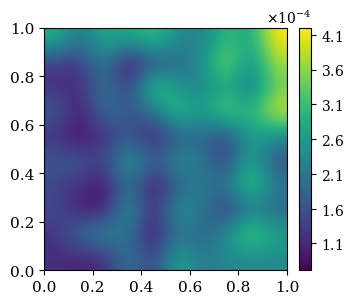

In [28]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(solution_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + ticks[1]/10)
cbar.set_ticks(new_ticks[1:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

Diffusivity $K(u)$

In [ ]:
validation_K = My(Mx(tf.convert_to_tensor(data['k_val'], dtype=tf.float32)))
predicted_K = predictions_explanatory_second_train
K_diff = np.mean(np.abs(predicted_K - validation_K), axis=0)

relative_error_stats(validation=validation_K, prediction=predicted_K)

Min: 1.09e-02
Max: 2.89e-01
First quartile (Q1): 1.80e-02
Second quartile (Q2): 4.58e-02
Third quartile (Q3): 5.72e-02


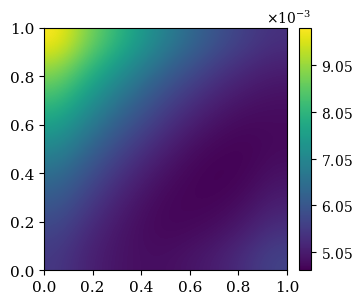

In [30]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(K_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.00005)
cbar.set_ticks(new_ticks[1:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

Flux $q_x$

In [ ]:
validation_qx = My(Mx(tf.convert_to_tensor(data['qx_val'], dtype=tf.float32)))
predicted_qx = predicted_K*Dx(predictions_predictive_second_train).numpy()
qx_diff = np.mean(np.abs(predicted_qx - validation_qx), axis=0)

relative_error_stats(validation=validation_qx, prediction=predicted_qx)

Min: 1.45e-02
Max: 3.84e+00
First quartile (Q1): 2.29e-02
Second quartile (Q2): 4.70e-02
Third quartile (Q3): 5.46e-02


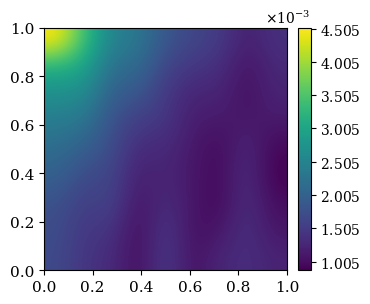

In [32]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(qx_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.000005)
cbar.set_ticks(new_ticks[1:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

Flux $q_y$

In [ ]:
validation_qy = My(Mx(tf.convert_to_tensor(data['qy_val'], dtype=tf.float32)))
predicted_qy = predicted_K*Dy(predictions_predictive_second_train).numpy()
qy_diff = np.mean(np.abs(predicted_qy - validation_qy), axis=0)

relative_error_stats(validation=validation_qy, prediction=predicted_qy)

Min: 1.27e-02
Max: 1.29e+01
First quartile (Q1): 2.14e-02
Second quartile (Q2): 4.57e-02
Third quartile (Q3): 5.27e-02


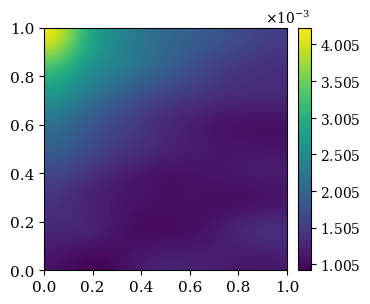

In [34]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(qy_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.000005)
cbar.set_ticks(new_ticks[1:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

In [35]:
validation_solution_tensor = Mx(My(tf.convert_to_tensor(validation_solution, dtype=tf.float32)))
predicted_solution_tensor = Mx(My(tf.convert_to_tensor(predicted_solution, dtype=tf.float32)))

reshaped_validation_solution = tf.reshape(validation_solution_tensor, [validation_solution_tensor.shape[0], -1]).numpy()
reshaped_predicted_solution = tf.reshape(predicted_solution_tensor, [predicted_solution_tensor.shape[0], -1]).numpy()
reshaped_validation_K = tf.reshape(validation_K, [validation_K.shape[0], -1]).numpy()
reshaped_predicted_K = tf.reshape(predicted_K, [predicted_K.shape[0], -1]).numpy()

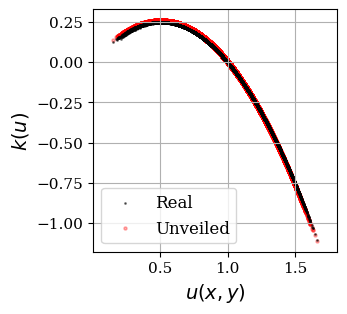

In [36]:
plt.figure(figsize=(height, height))

# Plot of the values
plt.scatter(reshaped_predicted_solution, reshaped_predicted_K, label='Unveiled', color='red', s=5, alpha=0.3)
plt.scatter(reshaped_validation_solution, reshaped_validation_K, label='Real', color='black', s=1, alpha=0.5)

# Labels configurations
plt.xlabel('$u(x, y)$', fontsize=label_fontsize)
plt.ylabel('$k(u)$', fontsize=label_fontsize)
plt.grid(True)

# Legend configuration
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0] 
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Axis configurations
min = np.min(reshaped_validation_solution) - 0.1*(np.max(reshaped_validation_solution - np.min(reshaped_validation_solution)))
max = np.max(reshaped_validation_solution) + 0.1*(np.max(reshaped_validation_solution - np.min(reshaped_validation_solution)))
plt.xlim(min, max)

# Show the image
plt.show()

In [37]:
def calcular_error_integrado(reshaped_predicted_K, reshaped_validation_K, x_step_size, y_step_size):
    """
    Calcula el error cuadrático integrado entre dos matrices de predicción y validación.

    Parámetros:
    reshaped_predicted_K (array): Valores predichos de la curva en una matriz 2D.
    reshaped_validation_K (array): Valores reales o validados de la curva en una matriz 2D.
    x_step_size (float): Paso de integración en la dirección x.
    y_step_size (float): Paso de integración en la dirección y.

    Retorna:
    float: El error cuadrático integrado.
    """
    # Numerador: diferencia de las matrices predicha y validada, integrada en ambas dimensiones
    numerador = np.sum((np.trapz(np.trapz(reshaped_predicted_K - reshaped_validation_K, dx=x_step_size), dx=y_step_size))**2)
    
    # Denominador: integral de los valores reales cuadrados en ambas dimensiones
    denominador = np.sum((np.trapz(np.trapz(reshaped_validation_K, dx=x_step_size), dx=y_step_size))**2)
    
    # Calcular el error cuadrático integrado
    er = numerador  / denominador
    
    print(f"er(K): {er:.2e}")


calcular_error_integrado(validation_K, predicted_K, x_step_size, y_step_size)

er(K): 1.14e-03


In [38]:
er = np.sum(np.trapz(reshaped_predicted_K.squeeze() - reshaped_validation_K.squeeze(), dx=x_step_size)**2)/np.sum(np.trapz(reshaped_validation_K.squeeze(), dx=x_step_size)**2)

print(f"er(K): {er:.2e}")

er(K): 1.19e-03


In [39]:
def relative_error_promedio(validation, prediction, dx=x_step_size, dy=y_step_size):

    validation = validation
    prediction = prediction
    
    numerator = np.sum(np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx))
    denominator = np.sum(np.trapz(np.trapz((validation)**2, dx=dy), dx=dx))

    print(f"{numerator/denominator:.2e}")

relative_error_promedio(validation_solution, predicted_solution)
relative_error_promedio(validation_K, predicted_K)
relative_error_promedio(validation_qx, predicted_qx)
relative_error_promedio(validation_qy, predicted_qy)

5.68e-08
1.08e-03
1.26e-03
1.22e-03


Predicted solutions

In [40]:
def calculate_error(validation_data, predicted_data):
    numerator = np.trapz(np.trapz((validation_data - predicted_data)**2))
    denominator = np.trapz(np.trapz((validation_data)**2))

    if np.all(denominator == 0):
        result = np.sqrt(numerator)
    else:
        result = np.sqrt(numerator / denominator)
    return result

def relative_error(validation, prediction):
    return (np.trapz(np.trapz((validation - prediction)**2))/np.trapz(np.trapz((validation)**2)))

solution


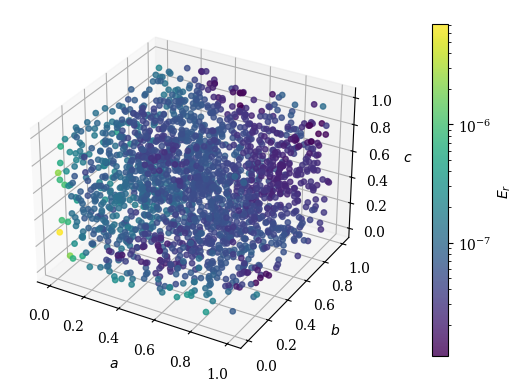

qx


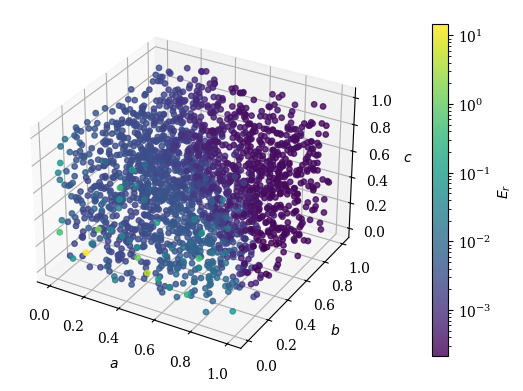

qy


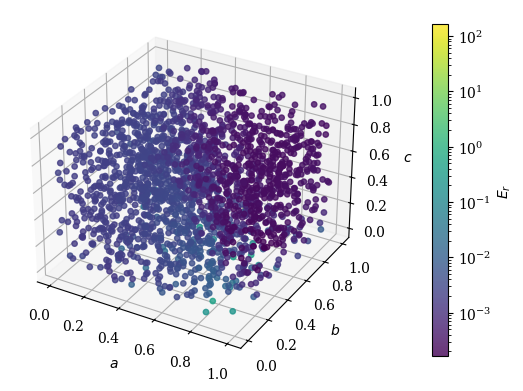

In [41]:
E_solution = relative_error(validation_solution, predicted_solution)
E_qx = relative_error(validation_qx, predicted_qx)
E_qy = relative_error(validation_qy, predicted_qy)

a = data['a_val']
b = data['b_val']
c = data['c_val']

def plot_error(a, b, c, error, variable):
    
    print(variable)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(a, b, c, c=error, cmap='viridis', s=15, alpha=0.8, norm=mcolors.LogNorm())
    cbar = plt.colorbar(sc, pad=0.12, shrink=0.9)
    cbar.set_label('$E_r$')

    ax.set_xlabel('$a$')
    ax.set_ylabel('$b$')
    ax.set_zlabel('$c$')

    plt.show()

plot_error(a=a, b=b, c=c, error=E_solution, variable='solution')
plot_error(a=a, b=b, c=c, error=E_qx, variable='qx')
plot_error(a=a, b=b, c=c, error=E_qy, variable='qy')